## LSTM for stock prediction

### Setting model parameter

In [1]:
import pandas as pd
from datetime import datetime
EPOCHS = 100
BATCH_SIZE = 32
TIME_STEPS = 32
OPTIMIZER = "adam"
LOSS = "mse"
MEAN = 10
PTC = True
STOCK_TICKER = 'IBM' # Ticker of company
STOCK_START_DATE = pd.to_datetime('2005-01-01')     # Train data from start date to validation date
STOCK_END_DATE = pd.to_datetime('2022-01-04')
STOCK_VALIDATION_PER = 0.2
CHECKPOINT_FOLDER = "./checkpoint/lstm"

### Read data and split data to train and test

In [2]:
import yfinance as yf
print("Train Data From: " + STOCK_START_DATE.strftime("%Y-%m-%d"), end=" ")
print('To: ' + STOCK_END_DATE.strftime("%Y-%m-%d"))
df = yf.download([STOCK_TICKER], start=STOCK_START_DATE, end=STOCK_END_DATE)
df.head()

Train Data From: 2005-01-01 To: 2022-01-04
[*********************100%***********************]  1 of 1 completed


,Open,High,Low,Close,Adj Close,Volume
Date,,,,,,
2004-12-31,94.263863,94.560226,94.158699,94.244743,57.603458,2921687
2005-01-03,94.617592,94.741875,92.973228,93.451241,57.118484,5538779
2005-01-04,93.441681,94.091782,92.275337,92.447418,56.504929,5973706
2005-01-05,92.351814,93.527725,92.160614,92.256210,56.388042,5906448
2005-01-06,92.294456,92.715103,91.826004,91.969406,56.212757,4771538


### Moving Average closing price

<AxesSubplot:title={'center':'Mean Close Price'}, xlabel='Date'>

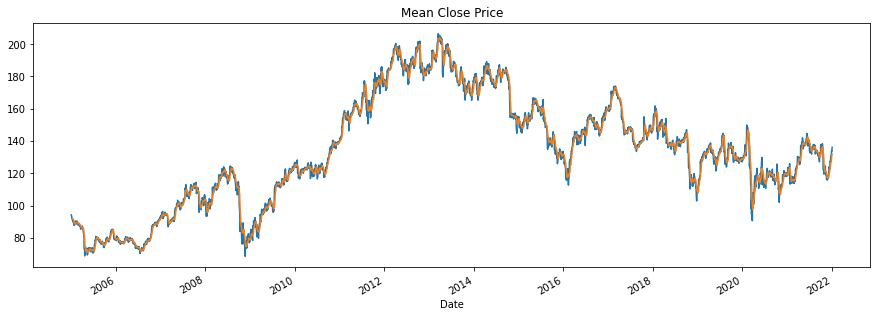

In [3]:
import matplotlib.pyplot as plt
df_mean = df.copy()
if MEAN > 1:
    # Apply moving average with a window of MEAN days to all columns
    df_mean[['Close']] = df[['Close']].rolling(MEAN).mean()
    # Drop all rows with NaN values
    df_mean.dropna(how='any', axis=0, inplace=True)
plt.figure(figsize=(15, 5))
df['Close'].plot(title="Close Price")
df_mean['Close'].plot(title="Mean Close Price")


### Calculate percentage change for all columns

In [4]:
if PTC:
    df_mean['Close'] = df_mean['Close'].pct_change()
    df_mean.dropna(how='any', axis=0, inplace=True) # Drop all rows with NaN values

### Data distribution

<AxesSubplot:xlabel='Close', ylabel='Count'>

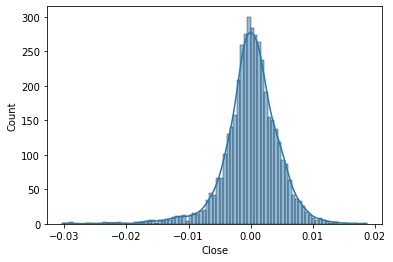

In [5]:
import seaborn as sns
sns.histplot(df_mean['Close'], kde=True)

### Split data

In [6]:
times = sorted(df_mean.index.values)
greater_train_index = times[-int(STOCK_VALIDATION_PER*len(times))]
df_train = df_mean[df_mean.index < greater_train_index].copy()
df_val = df_mean[df_mean.index >= greater_train_index].copy()

print('Training data shape: {}'.format(df_train.shape))
print('Validation data shape: {}'.format(df_val.shape))

Training data shape: (3418, 6)
Validation data shape: (854, 6)


### Plot daily changes of close prices and volume

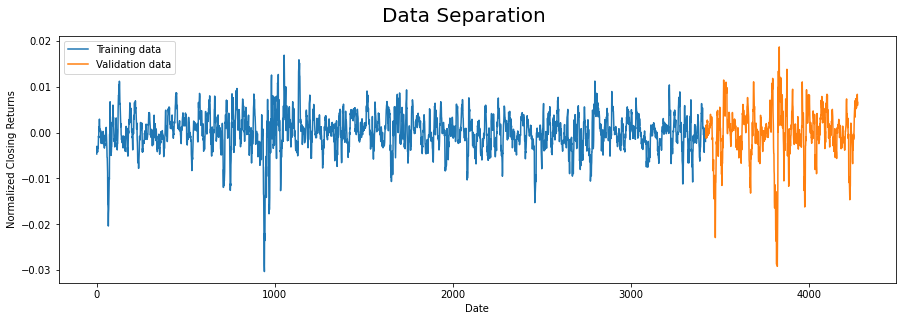

In [7]:
import numpy as np
fig = plt.figure(figsize=(15,10))
st = fig.suptitle("Data Separation", fontsize=20)
st.set_y(0.92)

###############################################################################

ax1 = fig.add_subplot(211)
ax1.plot(np.arange(df_train.shape[0]), df_train['Close'], label='Training data')

ax1.plot(np.arange(df_train.shape[0], 
                   df_train.shape[0]+df_val.shape[0]), df_val['Close'], label='Validation data')

ax1.set_xlabel('Date')
ax1.set_ylabel('Normalized Closing Returns')

plt.legend(loc='best')

### Normalization

In [8]:
from sklearn.preprocessing import MinMaxScaler
'''Normalize price columns'''
min_max = MinMaxScaler()
min_max.fit(df_mean[['Close']])
train_scaled = min_max.transform(df_train[['Close']])
val_scaled = min_max.transform(df_val[['Close']])

### Create data label by time sequence

In [9]:
import data
# Serialize data and generate labels for train data
x_train, y_train = data.create_data_label(train_scaled, TIME_STEPS)
x_validation, y_validation = data.create_data_label(val_scaled, TIME_STEPS)
print('Shape Of X_Train Data :')
print(x_train.shape)
print('Shape of X_Validation Data :')
print(x_validation.shape)

Shape Of X_Train Data :
(3386, 32, 1)
Shape of X_Validation Data :
(822, 32, 1)


### LSTM Model

In [11]:
from tensorflow.keras.models import *
from tensorflow.keras.layers import *
from tensorflow.keras.utils import plot_model
model = Sequential()
in_seq = InputLayer(input_shape = (x_train.shape[1], 1))
model.add(in_seq)
model.add(LSTM(units=128, return_sequences=True))
model.add(Dropout(0.25))
model.add(LSTM(units=64, return_sequences=True))
model.add(Dropout(0.25))
model.add(LSTM(units=64))
model.add(Dropout(0.25))
model.add(Dense(units=1))
model.summary()
plot_model(model, to_file='./img/model_lstm.png', show_shapes=True,
                              show_layer_names=True)
model.compile(optimizer=OPTIMIZER, loss=LOSS, metrics=[
    'mae'])

Model: "sequential_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
lstm_3 (LSTM)                (None, 32, 128)           66560     
_________________________________________________________________
dropout_3 (Dropout)          (None, 32, 128)           0         
_________________________________________________________________
lstm_4 (LSTM)                (None, 32, 64)            49408     
_________________________________________________________________
dropout_4 (Dropout)          (None, 32, 64)            0         
_________________________________________________________________
lstm_5 (LSTM)                (None, 64)                33024     
_________________________________________________________________
dropout_5 (Dropout)          (None, 64)                0         
_________________________________________________________________
dense_1 (Dense)              (None, 1)                

### Train model

In [28]:
import tensorflow as tf
history = model.fit(x_train, y_train, epochs=EPOCHS, batch_size=BATCH_SIZE, validation_data=(x_validation, y_validation),
                       callbacks=[tf.keras.callbacks.EarlyStopping(monitor='val_loss', patience=3, mode='min', verbose=1)])
model.save(CHECKPOINT_FOLDER)
#Print evaluation metrics for all datasets
train_eval = model.evaluate(x_train, y_train, verbose=0)
val_eval = model.evaluate(x_validation, y_validation, verbose=0)
print('Training Data - Loss: {:.4f}, MAE: {:.4f}'.format(train_eval[0], train_eval[1]))
print('Validation Data - Loss: {:.4f}, MAE: {:.4f}'.format(val_eval[0], val_eval[1]))

Epoch 1/100
106/106 [==============================] - 17s 97ms/step - loss: 0.0206 - mae: 0.1016 - val_loss: 0.0133 - val_mae: 0.0836
Epoch 2/100
106/106 [==============================] - 12s 111ms/step - loss: 0.0091 - mae: 0.0733 - val_loss: 0.0124 - val_mae: 0.0811
Epoch 3/100
106/106 [==============================] - 11s 103ms/step - loss: 0.0083 - mae: 0.0703 - val_loss: 0.0118 - val_mae: 0.0779
Epoch 4/100
106/106 [==============================] - 10s 91ms/step - loss: 0.0075 - mae: 0.0663 - val_loss: 0.0105 - val_mae: 0.0737
Epoch 5/100
106/106 [==============================] - 7s 70ms/step - loss: 0.0072 - mae: 0.0656 - val_loss: 0.0085 - val_mae: 0.0656
Epoch 6/100
106/106 [==============================] - 8s 71ms/step - loss: 0.0062 - mae: 0.0607 - val_loss: 0.0068 - val_mae: 0.0602
Epoch 7/100
106/106 [==============================] - 8s 73ms/step - loss: 0.0057 - mae: 0.0584 - val_loss: 0.0080 - val_mae: 0.0689
Epoch 8/100
106/106 [==============================] - 9

INFO:tensorflow:Assets written to: ./checkpoint/lstm\assets


INFO:tensorflow:Assets written to: ./checkpoint/lstm\assets


Training Data - Loss: 0.0015, MAE: 0.0296
Validation Data - Loss: 0.0030, MAE: 0.0385


### Visualize loss by epochs

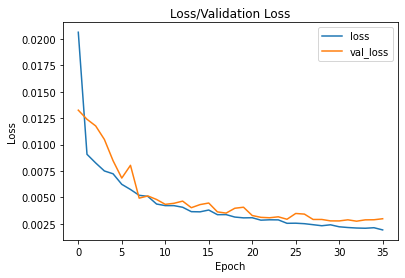

In [29]:
import visualize
visualize.visualize_loss(history)

### Set data to test

Test Data From: 2017-01-01 End Date: 2022-02-23
[*********************100%***********************]  1 of 1 completed


<AxesSubplot:title={'center':'Close Price'}, xlabel='Date'>

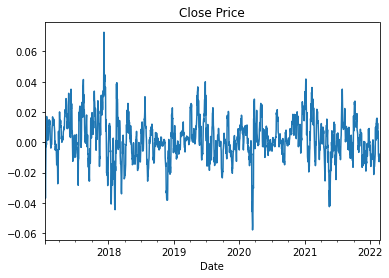

In [3]:
import pandas as pd
TEST_TICKER = 'BTC-USD'
STOCK_TEST_DATE = pd.to_datetime('2017-01-01') # Test data from this to now
import yfinance as yf
from datetime import datetime
print("Test Data From: " + STOCK_TEST_DATE.strftime("%Y-%m-%d"), end=" ")
end_date = datetime.today()
print('End Date: ' + end_date.strftime("%Y-%m-%d"))
test_data = yf.download([TEST_TICKER], start=STOCK_TEST_DATE, end=end_date)
if MEAN > 1:
    test_data[['Close']] = test_data[['Close']].rolling(MEAN).mean()
    test_data.dropna(how='any', axis=0, inplace=True) # Drop all rows with NaN values
if PTC:
    test_data['Close'] = test_data['Close'].pct_change()
    test_data.dropna(how='any', axis=0, inplace=True) # Drop all rows with NaN values
test_data['Close'].plot(title="Close Price")

In [4]:
from sklearn.preprocessing import MinMaxScaler
'''Normalize price columns'''
min_max_test = MinMaxScaler()
min_max_test.fit(test_data[['Close']])
test_scaled = min_max_test.transform(test_data[['Close']])

import data
# Serialize data and generate labels for train data
x_test, y_test = data.create_data_label(test_scaled, TIME_STEPS)
print('Shape Of X_Test Data :')
print(x_test.shape)

Shape Of X_Test Data :
(1839, 32, 1)


In [8]:
import visualize
import tensorflow as tf
model = tf.keras.models.load_model(CHECKPOINT_FOLDER)
test_predictions = model.predict(x_test)
print("predict shape")
print(test_predictions.shape)
# visualize.visualize_predict(y_test,
#     test_predictions, model_name="LSTM")
test_eval = model.evaluate(x_test, y_test, verbose=0)
print('Test Data - Loss: {:.4f}, MSE: {:.4f}'.format(test_eval[0], test_eval[1]))

('You must install pydot (`pip install pydot`) and install graphviz (see instructions at https://graphviz.gitlab.io/download/) ', 'for plot_model/model_to_dot to work.')
predict shape
(1839, 1)
Test Data - Loss: 0.0023, MSE: 0.0365


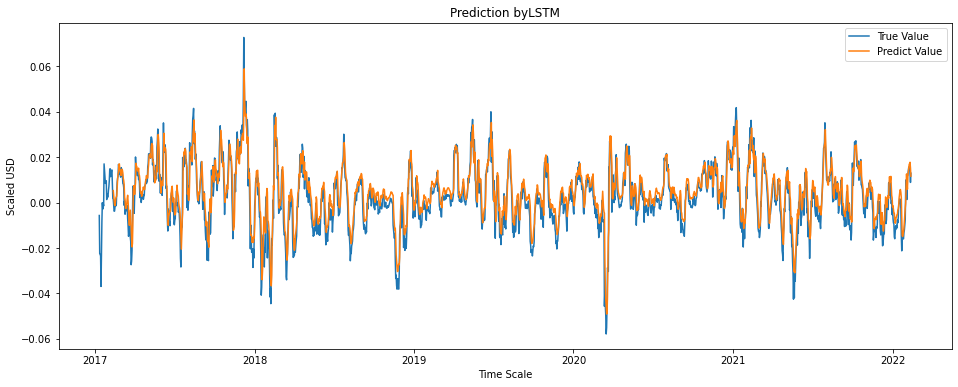

In [33]:
test_predictions = min_max_test.inverse_transform(test_predictions)
test_predictions = pd.DataFrame(test_predictions)
test_predictions.rename(
    columns={0: TEST_TICKER + '_predicted'}, inplace=True)
# test_predictions = test_predictions.round(decimals=0)
test_predictions.index = test_data[TIME_STEPS:].index
visualize.visualize_predict(test_data['Close'],
    test_predictions, model_name="LSTM")

In [34]:
print(test_predictions[-20:])
print(test_data['Close'][-20:])

            BTC-USD_predicted
Date                         
2022-01-24          -0.014960
2022-01-25          -0.014293
2022-01-26          -0.012953
2022-01-27          -0.011282
2022-01-28          -0.008069
2022-01-29          -0.005170
2022-01-30          -0.002369
2022-01-31          -0.000305
2022-02-01           0.007411
2022-02-02           0.012587
2022-02-03           0.008459
2022-02-04           0.005885
2022-02-05           0.011466
2022-02-06           0.013132
2022-02-07           0.014812
2022-02-08           0.016751
2022-02-09           0.017146
2022-02-10           0.017718
2022-02-11           0.015187
2022-02-12           0.011590
Date
2022-01-24   -0.015946
2022-01-25   -0.015646
2022-01-26   -0.015993
2022-01-27   -0.013269
2022-01-28   -0.012077
2022-01-29   -0.009602
2022-01-30   -0.007428
2022-01-31    0.005487
2022-02-01    0.010002
2022-02-02    0.001803
2022-02-03    0.001332
2022-02-04    0.012089
2022-02-05    0.012055
2022-02-06    0.013690
2022-02-07   